# **HW4P1: Language Modelling**

Welcome to the final Part 1 HW of this course. This is the only part 1 in which you have PyTorch training (Yay!). You will be working on training language models and evaluating them on the task of prediction and generation.<br>

As you go, please read the code and keep an eye out for TODOs.

Structure of this notebook:

- **Imports and installs** - specify the correct data paths and mostly just run it.
- **Datasets** - complete TODO and run it.
- **Dataloader** - complete TODO and run it.
- **Language model architecture** - implement and define your preferred model architecture based on the writeup.
- **Dataloader, model, loss, optimizer, and scheduler definition** - define your dataloader, model, loss, optimizer, and scheduler.
- **Trainer class** - unlike all the P2s, we are using a Trainer class for this HW, review the class and complete the train function.
- **Wandb** - add a correct API key.
- **Experiments** - just run your experiments and note the resulting NLL metric.
- **Evaluation** - get access to OpenAI API to get the resulting perplexity metric.
- **Submission** - create a handin for Autolab.

# **Imports and installs**

In [ ]:
!tar -xvf /content/hw4p1_handout.tar

handout/
handout/dataset/
handout/dataset/vocab.csv
handout/dataset/vocab.npy
handout/dataset/wiki.train.npy
handout/fixtures/
handout/fixtures/generation.npy
handout/fixtures/generation_test.npy
handout/fixtures/prediction.npz
handout/fixtures/prediction_test.npz
handout/hw4/
handout/hw4/attention.py
handout/hw4/hw4p1.ipynb
handout/hw4/hw4p1_autograder.py
handout/hw4/tests_hw4.py
handout/Makefile


In [ ]:
!pip install torchsummaryX
!pip install wandb --quiet
!pip install matplotlib
!pip install pandas==1.5.2

!pip install -q cohere tiktoken openai
!pip install openai==0.28

In [ ]:
# TODO: Import drive if you are using Colab

In [1]:
# You can upload entire working directory of HW4P1 to google drive and access the files from there

import sys
path = "/content/handout/" # TODO: Add path to handout. For example "content/handout"
sys.path.append(path)
%cd {path}

/content/handout


In [2]:
%matplotlib inline

import torch

import os

import time
import numpy as np
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
import torchsummaryX
import gc
import wandb
import yaml
import openai

# Importing necessary modules from hw4
# Update the path depending on how you choose to load the handout
from handout.hw4.tests_hw4 import get_prediction_nll, make_generation_text

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device: ", DEVICE)

Device:  cuda


# **Datasets**

In [3]:
# Loading the vocabulary. Try printing and see
VOCAB       = np.load('dataset/vocab.npy')

# We have also included <sos> and <eos> in the vocabulary for you
# However in real life, you include it explicitly if not provided
SOS_TOKEN   = np.where(VOCAB == '<sos>')[0][0]
EOS_TOKEN   = np.where(VOCAB == '<eos>')[0][0]
NUM_WORDS   = len(VOCAB) - 2 # Actual number of words in vocabulary

print("Vocab length: ", len(VOCAB))
print(VOCAB)
print(SOS_TOKEN)
print(EOS_TOKEN)

Vocab length:  33280
['!' '"' '#' ... '～' '<sos>' '<eos>']
33278
33279


In [4]:
# Loding the training dataset. Refer to write up section 2 to understand the structure
dataset     = np.load('dataset/wiki.train.npy', allow_pickle=True)

# The dataset does not have <sos> and <eos> because they are just regular articles.
# TODO: Add <sos> and <eos> to every article in the dataset.
for i in range(len(dataset)):
    dataset[i] = np.insert(dataset[i], 0, SOS_TOKEN)
    dataset[i] = np.append(dataset[i], EOS_TOKEN)
# Before doing so, try printing the dataset to see if they are words or integers.

In [5]:

print("数据类型：",type(dataset[0]))           #打印数组数据类型
print("数组元素数据类型：",dataset[0].dtype) #打印数组元素数据类型
print("数组元素总数：",dataset.size)      #打印数组尺寸，即数组元素总数
print("数组形状：",dataset.shape)         #打印数组形状
print("数组的维度数目：",dataset.ndim)      #打印数组的维度数目


数据类型： <class 'numpy.ndarray'>
数组元素数据类型： int64
数组元素总数： 579
数组形状： (579,)
数组的维度数目： 1


In [6]:
# Loading the fixtures for validation and test - prediction
fixtures_pred       = np.load('fixtures/prediction.npz')        # validation
fixtures_pred_test  = np.load('fixtures/prediction_test.npz')   # test

print("Validation shapes    : ", fixtures_pred['inp'].shape, fixtures_pred['out'].shape)
print("Test shapes          : ", fixtures_pred_test['inp'].shape)

Validation shapes    :  (128, 21) (128,)
Test shapes          :  (128, 21)


In [7]:
# Loading the test fixtures for generation
fixtures_gen_test   = np.load('fixtures/generation_test.npy')   # test

print("Test Gen Shapes          :", fixtures_gen_test.shape)

Test Gen Shapes          : (128, 31)


In [8]:
# Example Prediction Dev Input and Output
# Optional TODO: You can try printing a few samples from the validation set which has both inputs and output
print(dataset[0])
print(dataset[1])

[33278  1420 13859 ...    79  1417 33279]
[33278  1420 13463 ...    79  1417 33279]


# **Dataloader**

In [9]:
import random
class DataLoaderForLanguageModeling(torch.utils.data.DataLoader): # Inherit from torch.utils.data.DataLoader
    """
        TODO: Define data loader logic here
    """
    # TODO: You can probably add more parameters as well. Eg. sequence length
    def __init__(self, dataset, sequence_length, batch_size, shuffle= True, drop_last= False):

        # If you remember, these are the standard things which you give while defining a dataloader.
        # Now you are just customizing your dataloader
        self.dataset    = dataset
        self.sequence_length = sequence_length
        self.batch_size = batch_size
        self.shuffle    = shuffle
        self.drop_last  = drop_last

    def __len__(self):
        # What output do you get when you print len(loader)? You get the number of batches
        # Your dataset has (579, ) articles and each article has a specified amount of words.
        # You concatenate the dataset and then batch parts of it according to the sequence length
        # TODO: return the number of batches
        # If you are using variable sequence_length, the length might not be fixed
        return self.num_batches

    def __iter__(self):

        # TODO: Divide the concetenated dataset into inputs and targets. How do they vary?
        # TODO: Shuffle data if shuffle is True
        if (self.shuffle == True):
            np.random.shuffle(self.dataset)

        # TODO: Concatenate articles and then drop extra words that won't fit into a full batch
        concatenated_dataset = np.concatenate(self.dataset)
        total_length = len(concatenated_dataset) - len(concatenated_dataset) % (self.batch_size * self.sequence_length)
        self.num_batches =  total_length // (self.batch_size * self.sequence_length)

        # TODO: Think about how you could handle drop_last
        if self.drop_last:
            pass
        else:
            # Hint: Pad the last target sequence with EOS_TOKEN to ensure it has the same length as the other target sequences
            padding_length = (self.batch_size * self.sequence_length) - (len(concatenated_dataset) % (self.batch_size * self.sequence_length))
            if padding_length > 0:
                # Pad with EOS_TOKEN at the end
                padding = np.array([EOS_TOKEN] * padding_length)
                concatenated_dataset = np.concatenate([concatenated_dataset, padding])
                total_length = len(concatenated_dataset)

        self.concatenated_dataset = concatenated_dataset[:total_length]
        self.num_batches = total_length // (self.batch_size * self.sequence_length)
        # TODO: Reshape the inputs and targets into batches (think about the final shape)
        inputs = np.array([concatenated_dataset[i:i+self.sequence_length] for i in range(0, len(concatenated_dataset), self.sequence_length)])
        # drop the first element in concatenated_dataset
        concatenated_dataset = concatenated_dataset[1:]
        # add an EOS_TOKEN to the last
        concatenated_dataset = np.append(concatenated_dataset, EOS_TOKEN)
        targets = np.array([concatenated_dataset[i:i+self.sequence_length] for i in range(0, len(concatenated_dataset), self.sequence_length)])
        # TODO: Loop though the batches and yield the input and target batch according to the sequence length
        for i in range(0, len(self.concatenated_dataset), self.batch_size * self.sequence_length):
            batch_data = self.concatenated_dataset[i:i + self.batch_size * self.sequence_length]
            batch_data = batch_data.reshape(self.batch_size, self.sequence_length)

            # Input is all sequence except the last token
            input_batch = batch_data[:, :-1]
            # Target is all sequence except the first token
            target_batch = batch_data[:, 1:]

            yield input_batch, target_batch

In [10]:
# Some sanity checks

dl = DataLoaderForLanguageModeling(
    dataset     = dataset,
    batch_size  = 256,
    sequence_length= 5,
    shuffle     = True,
    drop_last   = True,
    # Input Extra parameters here if needed
)

inputs, targets = next(iter(dl))
print(inputs.shape, targets.shape)

for i, (x, y) in enumerate(dl):
    if i >= 5:
        break
    print("x: ", [VOCAB[i] for i in x[0, :]])
    print("y: ", [VOCAB[i] for i in y[0, :]])


(256, 4) (256, 4)
x:  ['<sos>', '=', 'Adams', 'River']
y:  ['=', 'Adams', 'River', '(']
x:  ['in', 'just', 'seventeen', 'days']
y:  ['just', 'seventeen', 'days', '.']
x:  ['he', 'was', 'consecrated', 'by']
y:  ['was', 'consecrated', 'by', 'Archbishop']
x:  ['to', 'him', 'was', 'the']
y:  ['him', 'was', 'the', 'study']
x:  ['in', 'monasteries', 'and', 'other']
y:  ['monasteries', 'and', 'other', 'venues']


# **Language model architecture**

Recurrent network, one-directional or bidirectional, captures certain patterns within a sequence, and can store them into state vector or pass into output. As with convolutional networks, we can build another recurrent layer on top of the first one to capture higher level patterns, build from low-level patterns extracted by the first layer. This leads us to the notion of multi-layer RNN, which consists of two or more recurrent networks, where output of the previous layer is passed to the next layer as input.

**Link to PyTorch Documentation**: [LSTM Cell](https://pytorch.org/docs/stable/generated/torch.nn.LSTMCell.html)

The following image can be a helpful aid in visualizing the flow of information in a multi-layer RNN with LSTM Cells.

<img src="https://raw.githubusercontent.com/microsoft/AI-For-Beginners/32043fd2c98de6bbcae857058ac38aaa8140b142/lessons/5-NLP/16-RNN/images/multi-layer-lstm.jpg">




In [91]:
class LanguageModel(torch.nn.Module):

    def __init__(self, vocab_size, embedding_dim=256, hidden_dim=256, num_layers=4):
        super().__init__()

        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.token_embedding = torch.nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim)

        lstm_cells = []
        for _ in range(num_layers):
              lstm_cells.append(torch.nn.LSTMCell(input_size=embedding_dim if len(lstm_cells) == 0 else hidden_dim, hidden_size=hidden_dim))
        self.lstm_cells = torch.nn.ModuleList(lstm_cells)

        self.token_probability = torch.nn.Linear(in_features=hidden_dim, out_features=vocab_size)
        # (Optional) TODO: Weight Tying. You just need to make the embedding layer weights equal to the Linear layer weight.
        self.token_probability.weight = self.token_embedding.weight
        # So the basic pipline is:
        # word -> embedding -> lstm -> projection (linear) to get  probability distribution
        # And this is happening across all time steps

    def rnn_step(self, embedding, hidden_states_list):
        next_hidden_states_list = []
        token_embedding = embedding
        token_embedding.to(DEVICE)
        for i, lstm_cell in enumerate(self.lstm_cells):
            tmp = (hidden_states_list[i][0].to(DEVICE), hidden_states_list[i][1].to(DEVICE))
            hidden_state, cell_state = lstm_cell(token_embedding, tmp)
            token_embedding = hidden_state
            next_hidden_states_list.append((hidden_state, cell_state))
        return token_embedding, next_hidden_states_list

    def predict(self, x):
        if not torch.is_tensor(x):
            x = torch.tensor(x).long().to(DEVICE)

        with torch.inference_mode():
            token_prob_dist, _ = self.forward(x)
            return token_prob_dist[:, -1, :]

    def generate(self, x, timesteps):
        timesteps -= 1
        x = torch.tensor(x).long().to(DEVICE)

        token_prob_dist, hidden_states_list = self.forward(x)

        # Draw the next predicted token from the probability distribution ()
        # the next prediction token is the index of the maximum value in the probability distribution
        # token_prob_dist is a tensor(batch_size, seq_len, vocab_size)
        next_token                         = torch.argmax(token_prob_dist[:, -1, :], dim= -1)
        next_token                         = next_token.unsqueeze(1)
        # Initialize the generated_sequence with next_token append to x
        generated_sequence  = torch.cat((x, next_token), dim=1)

        with torch.inference_mode():
            for t in range(timesteps):
                token_embedding, hidden_states_list = self.rnn_step(self.token_embedding(next_token)[:, -1, :], hidden_states_list)
                next_token = torch.argmax(self.token_probability(token_embedding), dim= -1)
                next_token = next_token.unsqueeze(1)
                # Update input for next prediction
                generated_sequence = torch.cat((x, next_token), dim=1)

        return generated_sequence


    def forward(self, x, hidden_states_list=None):
        x = x.long()
        batch_size, timesteps = x.shape
        #print("Input shape (batch_size, timesteps):", batch_size, timesteps)

        token_prob_distribution = [] # list which will contain probability distributions for all timesteps
        hidden_states_list = [(torch.zeros(batch_size, self.hidden_dim), torch.zeros(batch_size, self.hidden_dim))] * len(self.lstm_cells) if hidden_states_list == None else hidden_states_list

        token_embeddings = self.token_embedding(x)  # Shape: (Batch, Seq_len, Embedding_dim)
        token_embeddings = token_embeddings.to(DEVICE)
        #print("Token embeddings shape:", token_embeddings.shape)

        for t in range(timesteps): # LSTMCell is for just 1 timestep. Hence you need to loop through the total timesteps
            token_embedding_t = token_embeddings[:, t, :]
            #print("Token embedding at timestep", t, "shape:", token_embedding_t.shape)

            rnn_out, hidden_states_list = self.rnn_step(token_embedding_t, hidden_states_list)

            # Map the RNN output to the vocabulary’s dimension and store it in token_prob_dist_t,
            # the token probability distribution at time t.
            token_prob_dist_t = self.token_probability(rnn_out)
            #print("Token probability distribution at timestep", t, "shape:", token_prob_dist_t.shape)

            # Append token_prob_dist_t to a list of token probability distributions.
            token_prob_distribution.append(token_prob_dist_t)

        # Stack along the timesteps dimension
        token_prob_distribution = torch.stack(token_prob_distribution, dim=1)

        #print("Final token probability distribution shape:", token_prob_distribution.shape)


        return token_prob_distribution, hidden_states_list


# **Dataloader, model, loss, optimizer, and scheduler definition**

In [107]:
# TODO: Define other hyperparameters

config = dict(
    batch_size  = 256,
    num_epochs  = 15, # 10 to 20 epochs should be enough given the model is good
    init_lr     = 0.001 # TODO
)

In [108]:
# --------------------------------------------------- #

# TODO: Define the dataloader
loader = DataLoaderForLanguageModeling(dataset, sequence_length = 10, batch_size = config['batch_size'], shuffle= True, drop_last= False)

# --------------------------------------------------- #

# TODO: Define the model
model = LanguageModel(33280, embedding_dim=300, hidden_dim=300, num_layers=4) # TODO: Add more parameters as needed

# --------------------------------------------------- #

# TODO: Define the criterion
criterion   = torch.nn.CrossEntropyLoss()

# --------------------------------------------------- #

# TODO: Define the optimizer
## Adam/AdamW usually works good for this HW
optimizer = torch.optim.AdamW(model.parameters(), lr=config['init_lr'], weight_decay=0.5)

# --------------------------------------------------- #

# TODO: Define scheduler
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20, eta_min=0)  # eta_min is the minimum learning rate

# --------------------------------------------------- #

#TODO: Define scaler for mixed precision
scaler = torch.cuda.amp.GradScaler()

In [109]:
print(model)
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
summary = torchsummaryX.summary(model.to(DEVICE), x = torch.tensor(inputs).to(DEVICE))

LanguageModel(
  (token_embedding): Embedding(33280, 300)
  (lstm_cells): ModuleList(
    (0): LSTMCell(300, 300)
    (1): LSTMCell(300, 300)
    (2): LSTMCell(300, 300)
    (3): LSTMCell(300, 300)
  )
  (token_probability): Linear(in_features=300, out_features=33280, bias=True)
)
                          Kernel Shape   Output Shape     Params  Mult-Adds
Layer                                                                      
0_token_embedding         [300, 33280]  [256, 4, 300]     9.984M    9984000
1_lstm_cells.LSTMCell_0              -     [256, 300]     722.4k     720000
2_lstm_cells.LSTMCell_1              -     [256, 300]     722.4k     720000
3_lstm_cells.LSTMCell_2              -     [256, 300]     722.4k     720000
4_lstm_cells.LSTMCell_3              -     [256, 300]     722.4k     720000
5_token_probability       [300, 33280]   [256, 33280]  10.01728M    9984000
6_lstm_cells.LSTMCell_0              -     [256, 300]          -     720000
7_lstm_cells.LSTMCell_1           

/usr/local/lib/python3.10/dist-packages/torchsummaryX/torchsummaryX.py:101: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_sum = df.sum()


# **Trainer class**

In [110]:
# Unlike all the P2s, we are using a Trainer class for this HW.
# Many researchers also use classes like this for training. You may have encountered them in your project as well.
# You dont have to complete everything in this class, you only need to complete the train function.
# However, its good to go through the code and see what it does.

class Trainer:
    def __init__(self, model, loader, optimizer, criterion, scheduler, scaler, max_epochs= 1, run_id= 'exp'):
        """
            Use this class to train your model
        """
        # feel free to add any other parameters here
        self.model      = model
        self.loader     = loader
        self.optimizer  = optimizer
        self.criterion  = criterion
        self.scheduler  = scheduler
        self.scaler     = scaler

        self.train_losses           = []
        self.val_losses             = []
        self.prediction_probs       = []
        self.prediction_probs_test  = []
        self.generated_texts_test   = []
        self.epochs                 = 0
        self.max_epochs             = max_epochs
        self.run_id                 = run_id


    def calculate_loss(self, out, target):
        # output: (B, T, Vocab_size) - probability distributions
        # target: (B, T)
        # Read the documentation of CrossEntropyLoss and try to understand how it takes inputs

        # Tip: If your target is of shape (B, T) it means that you have B batches with T words.
        # Tip: What is the total number of words in this batch?
        # Tip: Crossentropy calculates the loss between a label and its probability distribution.

    # Reshape output and target for calculation

        outputs = out.view(-1, self.model.vocab_size)
        targets = target.view(-1)
        loss    = self.criterion(outputs, targets)

        return loss


    def train(self):

        self.model.train() # set to training mode
        self.model.to(DEVICE)
        epoch_loss  = 0
        num_batches = 0

        for batch_num, (inputs, targets) in enumerate(tqdm(self.loader)):

            # TODO: Complete the loop. You should be able to complete this without any helper comments after 3 HWs
            # Tip: Use Mixed Precision Training
            # For loss calculation, use the calculate_loss function. You need to complete it before using.

            inputs = torch.tensor(inputs).long().to(DEVICE)
            targets = torch.tensor(targets).long().to(DEVICE)

            self.optimizer.zero_grad()

            with torch.cuda.amp.autocast():
                outputs,_ = self.model(inputs)
                loss = self.calculate_loss(outputs, targets)

            self.scaler.scale(loss).backward()
            self.scaler.step(self.optimizer)
            self.scaler.update()

            epoch_loss += loss.item()

            # TODO: Add backward and, optimiser step and scaler update code here:
        self.scheduler.step()
        epoch_loss = epoch_loss / (batch_num + 1)
        self.epochs += 1
        print('[TRAIN] \tEpoch [%d/%d] \tLoss: %.4f \tLr: %.6f'
                    % (self.epochs, self.max_epochs, epoch_loss, self.optimizer.param_groups[0]['lr']))
        self.train_losses.append(epoch_loss)

        return (epoch_loss, self.optimizer.param_groups[0]['lr'])



    def test(self): # Don't change this function

        self.model.eval() # set to eval mode
        prediction_probs     = self.model.predict(fixtures_pred['inp']).detach().cpu().numpy() # get predictions
        self.prediction_probs.append(prediction_probs)

        generated_indexes_test   = self.model.generate(fixtures_gen_test, 10).detach().cpu().numpy() # generated predictions for 10 words

        nll                   = get_prediction_nll(prediction_probs, fixtures_pred['out'])
        generated_texts_test  = make_generation_text(fixtures_gen_test, generated_indexes_test, VOCAB)
        self.val_losses.append(nll)

        self.generated_texts_test.append(generated_texts_test)

        # generate predictions for test data
        prediction_probs_test = self.model.predict(fixtures_pred_test['inp']).detach().cpu().numpy() # get predictions
        self.prediction_probs_test.append(prediction_probs_test)

        print('[VAL] \tEpoch [%d/%d] \tLoss: %.4f'
                      % (self.epochs, self.max_epochs, nll))
        return nll


    def save(self): # Don't change this function

        model_path = os.path.join('hw4/experiments', self.run_id, 'model-{}.pkl'.format(self.epochs))
        torch.save({'state_dict': self.model.state_dict()}, model_path)
        np.save(os.path.join('hw4/experiments', self.run_id, 'prediction-probs-{}.npy'.format(self.epochs)), self.prediction_probs[-1])
        np.save(os.path.join('hw4/experiments', self.run_id, 'prediction-probs-test-{}.npy'.format(self.epochs)), self.prediction_probs_test[-1])

        with open(os.path.join('hw4/experiments', self.run_id, 'generated-texts-{}-test.txt'.format(self.epochs)), 'w') as fw:
            fw.write(self.generated_texts_test[-1])

In [111]:
# Dont change this cell

run_id = str(int(time.time()))
if not os.path.exists('./hw4/experiments'):
    os.mkdir('./hw4/experiments')
os.mkdir('./hw4/experiments/%s' % run_id)
print("Saving models, prediction prbabilities, and generated texts to ./hw4/experiments/%s" % run_id)

# The object of the Trainer class takes in everything
trainer = Trainer(
    model       = model,
    loader      = loader,

    optimizer   = optimizer,
    criterion   = criterion,
    scheduler   = scheduler,
    scaler      = scaler,
    max_epochs  = config['num_epochs'],
    run_id      = run_id
)

Saving models, prediction prbabilities, and generated texts to ./hw4/experiments/1713153091


# **Wandb**

In [112]:
# Use wandb? Resume Training?
USE_WANDB = True
RESUME_LOGGING = False

# Create your wandb run

run_name = "hw4p1_tie_10_300_0.5"

if USE_WANDB:

    wandb.login(key="0b52cf4a980eb59babb2048eeca50fdeb9de90ac")

    if RESUME_LOGGING:
        run_id = ''
        run = wandb.init(
            id     = run_id, ### Insert specific run id here if you want to resume a previous run
            resume = "must", ### You need this to resume previous runs, but comment out reinit = True when using this
            project = "hw4p1-s24", ### Project should be created in your wandb account
        )
    else:
        run = wandb.init(
            name    = run_name, ### Wandb creates random run names if you skip this field, we recommend you give useful names
            reinit  = True, ### Allows reinitalizing runs when you re-run this cell
            project = "hw4p1-s24", ### Project should be created in your wandb account
            config  = config ### Wandb Config for your run
        )

        ### Save your model architecture as a string with str(model)
        model_arch  = str(model)
        ### Save it in a txt file
        arch_file   = open("model_arch.txt", "w")
        file_write  = arch_file.write(model_arch)
        arch_file.close()

        ### log it in your wandb run with wandb.save()
        wandb.save('model_arch.txt')

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


# **Experiments**

In [113]:
# Run the experiments loop.
# Each epoch wont take more than 2-3min. If its taking more time, it might be due to (but not limited to) the following:
#   * You might be overlapping batches
#       Eg. Input: "I had biryani for lunch today" and sequence length = 3,
#           --> "I had biryani", "for lunch today" are ideal examples for inputs
#           --> "I had biryani", "had biryani for", "biryani for lunch", ... is just redundant info :')
#   * Your length calculation in the dataloader might be wrong
# If you haven't had biryani, try it :D

wandb.watch(model, log="all")

torch.cuda.empty_cache()
gc.collect()

# %%time
best_nll = 1e30
for epoch in range(config['num_epochs']):
    train_loss, curr_lr = trainer.train()
    nll = trainer.test()
    if nll < best_nll:
        best_nll = nll
        print("Saving model, prediction probabilities and generated texts for epoch "+str(epoch+1)+" with NLL: "+ str(best_nll))
        trainer.save()

    wandb.log({"train_loss":train_loss,
               "nll": nll,
               "learning_rate": curr_lr
              })

### Finish your wandb run
run.finish()

0it [00:00, ?it/s]

[TRAIN] 	Epoch [1/15] 	Loss: 6.9131 	Lr: 0.000994
[VAL] 	Epoch [1/15] 	Loss: 5.6207
Saving model, prediction probabilities and generated texts for epoch 1 with NLL: 5.620656


  0%|          | 0/812 [00:00<?, ?it/s]

[TRAIN] 	Epoch [2/15] 	Loss: 6.1569 	Lr: 0.000976
[VAL] 	Epoch [2/15] 	Loss: 5.3475
Saving model, prediction probabilities and generated texts for epoch 2 with NLL: 5.347481


  0%|          | 0/812 [00:00<?, ?it/s]

[TRAIN] 	Epoch [3/15] 	Loss: 5.8933 	Lr: 0.000946
[VAL] 	Epoch [3/15] 	Loss: 5.0660
Saving model, prediction probabilities and generated texts for epoch 3 with NLL: 5.065997


  0%|          | 0/812 [00:00<?, ?it/s]

[TRAIN] 	Epoch [4/15] 	Loss: 5.7165 	Lr: 0.000905
[VAL] 	Epoch [4/15] 	Loss: 5.0368
Saving model, prediction probabilities and generated texts for epoch 4 with NLL: 5.0368214


  0%|          | 0/812 [00:00<?, ?it/s]

[TRAIN] 	Epoch [5/15] 	Loss: 5.5950 	Lr: 0.000854
[VAL] 	Epoch [5/15] 	Loss: 4.8170
Saving model, prediction probabilities and generated texts for epoch 5 with NLL: 4.817025


  0%|          | 0/812 [00:00<?, ?it/s]

[TRAIN] 	Epoch [6/15] 	Loss: 5.4865 	Lr: 0.000794
[VAL] 	Epoch [6/15] 	Loss: 4.8918


  0%|          | 0/812 [00:00<?, ?it/s]

[TRAIN] 	Epoch [7/15] 	Loss: 5.4005 	Lr: 0.000727
[VAL] 	Epoch [7/15] 	Loss: 4.7561
Saving model, prediction probabilities and generated texts for epoch 7 with NLL: 4.756126


  0%|          | 0/812 [00:00<?, ?it/s]

[TRAIN] 	Epoch [8/15] 	Loss: 5.3385 	Lr: 0.000655
[VAL] 	Epoch [8/15] 	Loss: 4.7028
Saving model, prediction probabilities and generated texts for epoch 8 with NLL: 4.7027636


  0%|          | 0/812 [00:00<?, ?it/s]

[TRAIN] 	Epoch [9/15] 	Loss: 5.2739 	Lr: 0.000578
[VAL] 	Epoch [9/15] 	Loss: 4.6975
Saving model, prediction probabilities and generated texts for epoch 9 with NLL: 4.69746


  0%|          | 0/812 [00:00<?, ?it/s]

[TRAIN] 	Epoch [10/15] 	Loss: 5.2228 	Lr: 0.000500
[VAL] 	Epoch [10/15] 	Loss: 4.5959
Saving model, prediction probabilities and generated texts for epoch 10 with NLL: 4.595936


  0%|          | 0/812 [00:00<?, ?it/s]

[TRAIN] 	Epoch [11/15] 	Loss: 5.1815 	Lr: 0.000422
[VAL] 	Epoch [11/15] 	Loss: 4.5390
Saving model, prediction probabilities and generated texts for epoch 11 with NLL: 4.5390253


  0%|          | 0/812 [00:00<?, ?it/s]

[TRAIN] 	Epoch [12/15] 	Loss: 5.1328 	Lr: 0.000345
[VAL] 	Epoch [12/15] 	Loss: 4.5751


  0%|          | 0/812 [00:00<?, ?it/s]

[TRAIN] 	Epoch [13/15] 	Loss: 5.0895 	Lr: 0.000273
[VAL] 	Epoch [13/15] 	Loss: 4.5783


  0%|          | 0/812 [00:00<?, ?it/s]

[TRAIN] 	Epoch [14/15] 	Loss: 5.0518 	Lr: 0.000206
[VAL] 	Epoch [14/15] 	Loss: 4.5247
Saving model, prediction probabilities and generated texts for epoch 14 with NLL: 4.5247407


  0%|          | 0/812 [00:00<?, ?it/s]

[TRAIN] 	Epoch [15/15] 	Loss: 5.0153 	Lr: 0.000146
[VAL] 	Epoch [15/15] 	Loss: 4.5391


learning_rate,███▇▇▆▆▅▅▄▃▃▂▁▁
nll,█▆▄▄▃▃▂▂▂▁▁▁▁▁▁
train_loss,█▅▄▄▃▃▂▂▂▂▂▁▁▁▁
learning_rate,0.00015
nll,4.53908
train_loss,5.01526


In [106]:
run.finish()

learning_rate,██▇▆▅▄▂▁
nll,█▅▄▃▂▂▁▁
train_loss,█▅▄▃▂▂▁▁
learning_rate,0.00065
nll,4.79304
train_loss,5.37807


In [114]:
torch.cuda.empty_cache()
gc.collect()

656

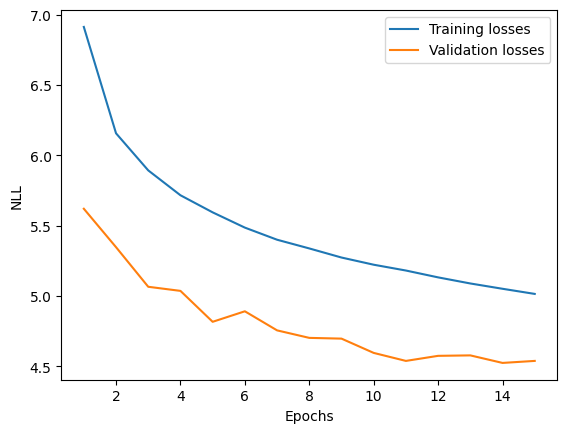

In [115]:
plt.figure()
plt.plot(range(1, trainer.epochs + 1), trainer.train_losses, label='Training losses')
plt.plot(range(1, trainer.epochs + 1), trainer.val_losses, label='Validation losses')
plt.xlabel('Epochs')
plt.ylabel('NLL')
plt.legend()
plt.show()

# **Evaluation**

 - Now that you have trained your model and got satisfactory validation NLL on the single token prediction task, you can evaluate the generations you created too
 - We will use the perplexity metric to evaluate generations using a large language model available through the OpenAI API. Read the handout for instructions on how to sign up for the API and obtain and API key.
 - Once you add credits to your account, run this cell to get the perplexity.
 - You will submit this perplexity value for grading the generation component of this homework.
 - A perplexity of under **1400** will give you full credit on the generation part.

Change only the **submission_run_id**, **submission_epoch**, and **api_key** in the following cell

In [116]:
# DO NOT CHANGE THE CODE IN THIS CELL EXCEPT submission_run_id, submission_epoch, AND api_key
# PLEASE BE HONEST IN REPORTING THE PERPLEXITY VALUE!
# WE WILL RANDOMLY CHECK SOME SUBMISSIONS USING THE SAME CODE AS THIS AND A BIG DIFFERENCE IN PERPLEXITY WILL RESULT IN AN AIV.

import openai

# Add you submission_run_id and submission_epoch here --------------------------------------------------
# Fill the run id and epoch number to be used for submission.
# You will use the same run id and epoch number to generate the handin.

submission_run_id = "1713153091"
submission_epoch = 14

# --------------------------------------------------------------

n_tests = 128

with open(os.path.join('hw4/experiments', submission_run_id, 'generated-texts-{}-test.txt'.format(submission_epoch)), 'r', encoding='utf-8') as f:
    generated = list(f)

assert len(generated) == n_tests
for item in generated:
    assert type(item) is str

parsed_generated = []

for text in generated:
    start_index = text.index("<sos>")
    temp = text[start_index+6:]
    generation_start_index = temp.index("| ")
    parsed_text = temp[:generation_start_index] + temp[generation_start_index+2:]
    parsed_text = parsed_text.replace("<eol>", "\n")
    parsed_generated.append(parsed_text)

def perplexity(text, modelname):
    """Compute the perplexity of the provided text."""
    completion = openai.Completion.create(
        model=modelname,
        prompt=text,
        logprobs=0,
        max_tokens=0,
        temperature=1.0,
        echo=True)
    token_logprobs = completion['choices'][0]['logprobs']['token_logprobs']
    ll = np.mean([i for i in token_logprobs if i is not None])
    ppl = np.exp(-ll)
    return ppl

# Add you API key here --------------------------------------------------
# However, delete the key from the notebook before creating the handin.
# REMEMBER: ALWAYS KEEP YOUR API KEYS AND SECRETS SECURE.

openai.api_key = '****' # TODO

# --------------------------------------------------------------

modelname = 'text-embedding-ada-002'

perps = [perplexity(text, modelname) for text in tqdm(parsed_generated)]
avg_perp = np.mean(perps)

# Report this number when running the makefile to create the handin
print("Your mean perplexity for generated sequences: {}".format(avg_perp))

  0%|          | 0/128 [00:00<?, ?it/s]

Your mean perplexity for generated sequences: 441.29391163545006


**NOTE**:
- If you get a "The server is overloaded or not ready yet" when trying to run the above cell, simply try re-running after some time.
- You will need to add credits ($5) to your open-ai account to get rid of the limit error.

# **Submission**
Navigate to the handout directory to run the below cell. This command will create the handin with all the required files (including attention.py). So make sure you have the entire handout directory wherever you are running this notebook (local machine, Colab, AWS, etc.).

**IMPORTANT NOTE:** This command requires that this c**ompleted notebook be in the hw4 folder inside the handout directory**. If you are on colab, this notebook you are working on **DOES NOT** live in the handout directory. You must **download it and then upload it** to the hw4 folder replacing the empty starter notebook.

In [117]:
# TODO: Generate the handin to submit to autolab

# For example:
# !make runid=1705009752 epoch=9 ppl=1287.0752467922216

!make runid=1713153091 epoch=14 ppl=441.29391163545006

make: *** No rule to make target '441.29391163545006'.  Stop.


In [ ]:
!echo 448.93014787535867 > generation_ppl.txt
!cp hw4/experiments/1713066276/prediction-probs-test-13.npy prediction_probs.npy
!cp hw4/experiments/1713066276/generated-texts-13-test.txt generated_texts.txt
!cp hw4/hw4p1.ipynb training.ipynb
!cp hw4/attention.py attention.py
!tar -cvzf handin.tar training.ipynb prediction_probs.npy generated_texts.txt generation_ppl.txt attention.py

training.ipynb
prediction_probs.npy
generated_texts.txt
generation_ppl.txt
attention.py
